<a href="https://colab.research.google.com/github/ChunTingShen/DS4B_project/blob/main/Coupon_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#If opening in colab run this cell
#!git clone https://github.com/bwolfson2/dsclass2022
!git clone https://github.com/ChunTingShen/DS4B_project
#%cd dsclass2022/Homeworks

Cloning into 'DS4B_project'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 42 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.


### Redeem Prediction:

Our target is to predict whether the promo code was redeemed on a purchase. The target variable is "y_redeemed" in the file proj_training_data.csv .

Since the data is already merged (thank you Prof!) , what we need to do next is to:

0. (define our target: predict "y_redeemed" )
1. clean the merged data: transform strings to date, strings(or float) to integer (for example: N_Children: 1.0, 2.0, 3+, Nan --> 1,2,3,-1)
2. perform EDA
3. create dummy variable
4. create training and testing datasets
5. modeling
6. make predictions
7. evaluation
8. deployment

Overall, we think this is pretty close to the HW2. So we try to modify the HW2 code and do the analysis on this existing template. 



In [1]:
# imports

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline
sns.set(style='ticks', palette='Set2')

import warnings
warnings.filterwarnings('ignore')



In [5]:
#input data:

path = "/content/proj_training_data.csv"

### path_sup = "/content/proj_training_data_supl.csv"
# not in use for now


import pandas as pd
import numpy as np

df = pd.read_csv(path)
print(len(df)) # should be 1102842
df.dropna()
print(len(df))

df.head()


1102842
1102842


y_redeemed  year      date  cust_id  prod_id  manuf   brand_type category  \
0           0  2013  02/22/13     1489    34047     56        Local  Grocery   
1           0  2013  02/22/13     1489    35464     56        Local  Grocery   
2           0  2013  03/03/13     1489    34047     56        Local  Grocery   
3           0  2013  03/03/13     1489    33688    939  Established  Grocery   
4           0  2013  03/05/13     1489    34047     56        Local  Grocery   

   y_qty   price  ...  c_type  start_date  end_date redemption_id age_cohort  \
0      1   91.19  ...       X    02/16/13  05/04/13             9      46-55   
1      1   21.02  ...       X    02/16/13  05/04/13             9      46-55   
2      1   91.19  ...       X    02/16/13  05/04/13             9      46-55   
3      1  124.31  ...       X    02/16/13  05/04/13             9      46-55   
4      1   91.19  ...       X    02/16/13  05/04/13             9      46-55   

  marital_status  home_is_rental n_family no_of_children  income_range  
0        Married             0.0      2.0            NaN           3.0  
1        Married             0.0      2.0            NaN           3.0  
2        Married             0.0      2.0            NaN           3.0  
3        Married             0.0      2.0            NaN           3.0  
4        Married             0.0      2.0            NaN           3.0  

[5 rows x 23 columns]

In [6]:
### data cleaning:

### convert date format:

df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df['start_date'] = pd.to_datetime(df['start_date'], format='%m/%d/%y')
df['end_date'] = pd.to_datetime(df['end_date'], format='%m/%d/%y')



### convert type from float or string to integer

df['marital_status'] = df['marital_status'].replace(np.nan, -1)

df['home_is_rental'] = df['home_is_rental'].replace(np.nan, -1)
df['home_is_rental'] = df['home_is_rental'].astype(int)

df['age_cohort'] = df['age_cohort'].replace(np.nan, -1)
df['age_cohort'] = df['age_cohort'].replace("18-25", "18_25") 
df['age_cohort'] = df['age_cohort'].replace("26-35", "26_35")
df['age_cohort'] = df['age_cohort'].replace("36-45", "36_45")
df['age_cohort'] = df['age_cohort'].replace("46-55", "46_55")
df['age_cohort'] = df['age_cohort'].replace("56-70", "56_70")
df['age_cohort'] = df['age_cohort'].replace("70+", "71")


df['n_family'] = df['n_family'].replace(np.nan, -1)
df['n_family'] = df['n_family'].replace("5+", 5)
df['n_family'] = df['n_family'].astype(int)


df['no_of_children'] = df['no_of_children'].replace(np.nan, -1) # if no response: label it as -1 
df['no_of_children'] = df['no_of_children'].replace("3+", 3)
df['no_of_children'] = df['no_of_children'].astype(int)


df['income_range'] = df['income_range'].replace(np.nan, -1)
df['income_range'] = df['income_range'].astype(int)


print(len(df))

# create promotion days:
df["promo_duration"] = df['end_date'] - df['start_date']
df["promo_duration"] = df["promo_duration"].dt.days



print(df.columns)

#df.dropna(axis='index', subset=['Sales'],inplace=True)
#df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
#df['StateHoliday'] = df['StateHoliday'].astype(str)
#df_train = df.loc[df['Date'] < '2014-07-01']
#df_test  = df.loc[df['Date'] >= '2014-07-01']

df_test  = df[df['date'] >= '2013/1/10']
df_train = df[df['date'] < '2013/1/10']


df[1048570:1048580]

1102842
Index(['y_redeemed', 'year', 'date', 'cust_id', 'prod_id', 'manuf',
       'brand_type', 'category', 'y_qty', 'price', 'dscnt_store',
       'y_dscnt_pcode', 'c_id', 'c_type', 'start_date', 'end_date',
       'redemption_id', 'age_cohort', 'marital_status', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'promo_duration'],
      dtype='object')


y_redeemed  year       date  cust_id  prod_id  manuf   brand_type  \
1048570           0  2013 2013-03-22     1438    10935     56        Local   
1048571           0  2013 2013-03-22     1438    30564     56        Local   
1048572           0  2013 2013-03-22     1438    52002     56        Local   
1048573           0  2013 2013-03-22     1438    52002     56        Local   
1048574           0  2013 2013-03-22     1438    67797   3799  Established   
1048575           0  2013 2013-03-27     1438     8062   4817  Established   
1048576           0  2013 2013-03-27     1438    10935     56        Local   
1048577           0  2013 2013-03-27     1438    13148     56        Local   
1048578           0  2013 2013-03-27     1438    27096     56        Local   
1048579           0  2013 2013-03-27     1438    32786     56        Local   

              category  y_qty   price  ...  start_date   end_date  \
1048570        Grocery      1   21.02  ...  2013-02-16 2013-05-04   
1048571        Grocery      1   47.37  ...  2013-02-16 2013-05-04   
1048572        Grocery      1   35.62  ...  2013-02-16 2013-05-04   
1048573        Grocery      1   35.62  ...  2013-02-16 2013-05-04   
1048574           Meat      1  425.30  ...  2013-02-16 2013-05-04   
1048575        Grocery      1   35.62  ...  2013-02-16 2013-05-04   
1048576        Grocery      1   21.02  ...  2013-02-16 2013-05-04   
1048577  Packaged Meat      1  248.98  ...  2013-02-16 2013-05-04   
1048578           Meat      1  247.56  ...  2013-02-16 2013-05-04   
1048579        Grocery      1   99.38  ...  2013-02-16 2013-05-04   

         redemption_id age_cohort marital_status home_is_rental  n_family  \
1048570          98350         -1             -1             -1        -1   
1048571          98350         -1             -1             -1        -1   
1048572          98350         -1             -1             -1        -1   
1048573          98350         -1             -1             -1        -1   
1048574          98350         -1             -1             -1        -1   
1048575          98350         -1             -1             -1        -1   
1048576          98350         -1             -1             -1        -1   
1048577          98350         -1             -1             -1        -1   
1048578          98350         -1             -1             -1        -1   
1048579          98350         -1             -1             -1        -1   

        no_of_children income_range  promo_duration  
1048570             -1           -1              77  
1048571             -1           -1              77  
1048572             -1           -1              77  
1048573             -1           -1              77  
1048574             -1           -1              77  
1048575             -1           -1              77  
1048576             -1           -1              77  
1048577             -1           -1              77  
1048578             -1           -1              77  
1048579             -1           -1              77  

[10 rows x 24 columns]

Perform EDA on training data:


In [7]:
#!pip install dataprep
import dataprep
from dataprep.eda import create_report

ModuleNotFoundError: ignored

The plot will not show in a notebook environment, please try 'show_browser' if you want to open it in browser



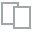
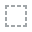
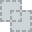
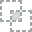
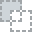
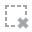
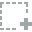
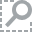
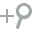
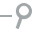
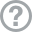
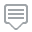
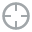
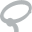
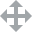
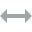
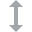
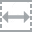
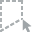
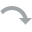
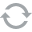
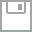
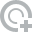
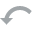
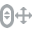
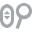
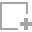
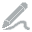
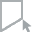
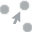
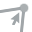
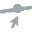

In [ ]:
create_report(df_train).show()


The first thing we notice is that only 1.3% of the data are "Redeemed", that is pretty low. 

In other words, if we simply predict nobody will ever redeemed anything, then we would have a 99% accuracy! 




Further perform more EDA on those redeemed:


In [8]:
df_redeemed = df_train[df_train['y_redeemed'] == 1]

The plot will not show in a notebook environment, please try 'show_browser' if you want to open it in browser



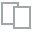
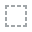
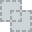
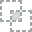
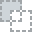
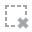
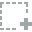
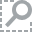
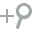
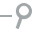
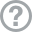
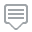
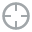
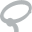
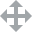
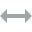
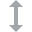
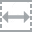
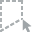
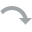
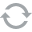
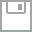
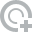
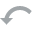
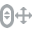
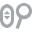
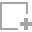
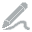
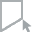
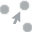
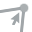
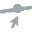

In [ ]:
create_report(df_redeemed).show()


Create dummy variables (for logistic regression):


In [11]:
# create dummies

#df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
#print(min(df['date']), max(df['date']))



df_test  = df[df['date'] >= '2013/1/10']
df_train = df[df['date'] < '2013/1/10']

df_train = pd.concat([df_train, ((pd.get_dummies(df_train['marital_status'], drop_first=True, prefix = "marital_status")))], axis = 1, join = 'inner')
df_train = pd.concat([df_train, ((pd.get_dummies(df_train['category'], drop_first=True, prefix = "category")))], axis = 1, join = 'inner')
df_train = pd.concat([df_train, ((pd.get_dummies(df_train['brand_type'], drop_first=True, prefix = "brand_type")))], axis = 1, join = 'inner')
df_train = pd.concat([df_train, ((pd.get_dummies(df_train['age_cohort'], drop_first=True, prefix = "age_cohort")))], axis = 1, join = 'inner')
df_train = pd.concat([df_train, ((pd.get_dummies(df_train['home_is_rental'], drop_first=True, prefix = "home_is_rental")))], axis = 1, join = 'inner')
df_train = pd.concat([df_train, ((pd.get_dummies(df_train['n_family'], drop_first=True, prefix = "n_family")))], axis = 1, join = 'inner')
df_train = pd.concat([df_train, ((pd.get_dummies(df_train['no_of_children'], drop_first=True, prefix = "no_of_children")))], axis = 1, join = 'inner')
df_train = pd.concat([df_train, ((pd.get_dummies(df_train['income_range'], drop_first=True, prefix = "income_range")))], axis = 1, join = 'inner')



target_col = "y_redeemed"
predictor_cols = ["redemption_id", "age_cohort", "income_range", "brand_type", "category", "marital_status"]
print(df_train.columns)

df_train[11100:11105]



Index(['y_redeemed', 'year', 'date', 'cust_id', 'prod_id', 'manuf',
       'brand_type', 'category', 'y_qty', 'price', 'dscnt_store',
       'y_dscnt_pcode', 'c_id', 'c_type', 'start_date', 'end_date',
       'redemption_id', 'age_cohort', 'marital_status', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'promo_duration',
       'marital_status_Married', 'marital_status_Single', 'category_Grocery',
       'category_Meat', 'category_Natural Products', 'category_Packaged Meat',
       'category_Pharmaceutical', 'category_Prepared Food', 'category_Seafood',
       'brand_type_Local', 'age_cohort_18_25', 'age_cohort_26_35',
       'age_cohort_36_45', 'age_cohort_46_55', 'age_cohort_56_70',
       'age_cohort_71', 'home_is_rental_0', 'home_is_rental_1', 'n_family_1',
       'n_family_2', 'n_family_3', 'n_family_4', 'n_family_5',
       'no_of_children_1', 'no_of_children_2', 'no_of_children_3',
       'income_range_1', 'income_range_2', 'income_range_3', 'income_range

y_redeemed  year       date  cust_id  prod_id  manuf   brand_type  \
119079           0  2012 2012-11-09     1167    13310   1337  Established   
119080           0  2012 2012-11-14     1167     9783   1337  Established   
119081           0  2012 2012-11-14     1167     7502   1337  Established   
119082           0  2012 2012-08-12     1167     9783   1337  Established   
119083           0  2012 2012-08-17     1167    25145   4790  Established   

       category  y_qty  price  dscnt_store  y_dscnt_pcode  c_id c_type  \
119079  Grocery      1  17.81       -10.33            0.0    29      Y   
119080  Grocery      1  21.37        -6.77            0.0    29      Y   
119081  Grocery      1  21.37        -6.77            0.0    29      Y   
119082  Grocery      2  42.74       -13.54            0.0    29      Y   
119083  Grocery      1  81.57         0.00            0.0    29      Y   

       start_date   end_date  redemption_id age_cohort marital_status  \
119079 2012-08-10 2012-11-30          62157      46_55             -1   
119080 2012-08-10 2012-11-30          62157      46_55             -1   
119081 2012-08-10 2012-11-30          62157      46_55             -1   
119082 2012-08-10 2012-11-30          62466      46_55             -1   
119083 2012-08-10 2012-11-30          62466      46_55             -1   

        home_is_rental  n_family  no_of_children  income_range  \
119079               0         1              -1             5   
119080               0         1              -1             5   
119081               0         1              -1             5   
119082               0         1              -1             5   
119083               0         1              -1             5   

        promo_duration  marital_status_Married  marital_status_Single  \
119079             112                       0                      0   
119080             112                       0                      0   
119081             112                       0                      0   
119082             112                       0                      0   
119083             112                       0                      0   

        category_Grocery  category_Meat  category_Natural Products  \
119079                 1              0                          0   
119080                 1              0                          0   
119081                 1              0                          0   
119082                 1              0                          0   
119083                 1              0                          0   

        category_Packaged Meat  category_Pharmaceutical  \
119079                       0                        0   
119080                       0                        0   
119081                       0                        0   
119082                       0                        0   
119083                       0                        0   

        category_Prepared Food  category_Seafood  brand_type_Local  \
119079                       0                 0                 0   
119080                       0                 0                 0   
119081                       0                 0                 0   
119082                       0                 0                 0   
119083                       0                 0                 0   

        age_cohort_18_25  age_cohort_26_35  age_cohort_36_45  \
119079                 0                 0                 0   
119080                 0                 0                 0   
119081                 0                 0                 0   
119082                 0                 0                 0   
119083                 0                 0                 0   

        age_cohort_46_55  age_cohort_56_70  age_cohort_71  home_is_rental_0  \
119079                 1                 0              0                 1   
119080                 1                 0              0                 1   
119081

In [12]:
print(len(df))
df[:10]
df["promo_duration"][:10]

1102842


0    77
1    77
2    77
3    77
4    77
5    77
6    77
7    77
8    77
9    77
Name: promo_duration, dtype: int64

The records starts from 2012/01/10 until 2013/04/14.

Here we can do a series of preliminary analyses. 

First, we take the 2013/1/10 as the cutting point (so we have a full year as training data). 

Records after 2013/1/10 will be testing data and before 2013/1/10 will be our training data. 


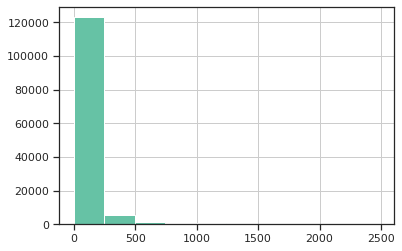

In [13]:
df_train['price'].hist()

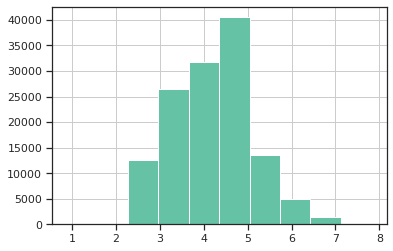

In [14]:
#max(df_train['date'])
#df_train[:-10]

df_train['lnPrice'] = np.log(df_train.price+1)           # add 1 to account for for zero sales days
df_train['lnPrice'].hist()                                # make sure everything looks OK





  # eliminate observations for closed stores
#working_df['lnSales'] = np.log(working_df.Sales+1)           # add 1 to account for for zero sales days
#working_df['lnSales'].hist()                                # make sure everything looks OK

#mu    = working_df.lnSales.mean()     # calculate mean for z-scores
#sigma = working_df.lnSales.std()      # calculate sd for z-scores
#x     = np.array(working_df.lnSales)  # convert to np.array to permit vectorization
#z     = (x - mu)/sigma

#working_df['zSales'] = z
#working_df['lowSalesFlag'] = np.where(z < -1, 1,0)

#working_df = pd.get_dummies(working_df, columns=['DayOfWeek'], drop_first=True, dummy_na=False)
#working_df = pd.get_dummies(working_df, columns=['StateHoliday'], drop_first=True, dummy_na=False)

#working_df

# Build a simple tree to see what might happened.



In [15]:
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline
sns.set(style='ticks', palette='Set2')

In [16]:
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()  
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot 
    

In [17]:
def cm2accuracy(tab):                    # convert 2x2 confusion matrix to accuracy (pct correct)
    correct  = (tab[0][0] + tab[1][1])
    total    = sum(sum(tab))
    accuracy = correct/total
    return(accuracy)

def bool2txt(x,text):
    if x==0 : 
        return text[0]
    else: 
        return text[1]


import copy as c
def Decision_Surface(data, col1, col2, target, orig_model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()

    # ipdb.set_trace()  # insert this line into any Python code for debugging.  'n' in the dialog box moves to the next line of code
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    # make a copy of the model so we don't corrupt the original
    model = c.deepcopy(orig_model)
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)  
        
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot    
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in df[target_col]]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="target", frameon=True)
    plt.show() 

def visualize_tree(decision_tree, feature_names, class_names, directory="./images", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)

In [18]:

target_col = "y_redeemed"
predictor_cols = ["redemption_id", "age_cohort", "income_range", "brand_type", "category", "marital_status"]

predictor_cols = ["price", "dscnt_store", "income_range", "n_family", "no_of_children", "age_cohort", "home_is_rental", "y_qty", "promo_duration"]

print(df.columns)


errorfile = df_train[df_train['income_range'] == np.nan]
errorfile[:10]

#df[:10]
#df[112090:112095]



Index(['y_redeemed', 'year', 'date', 'cust_id', 'prod_id', 'manuf',
       'brand_type', 'category', 'y_qty', 'price', 'dscnt_store',
       'y_dscnt_pcode', 'c_id', 'c_type', 'start_date', 'end_date',
       'redemption_id', 'age_cohort', 'marital_status', 'home_is_rental',
       'n_family', 'no_of_children', 'income_range', 'promo_duration'],
      dtype='object')


Empty DataFrame
Columns: [y_redeemed, year, date, cust_id, prod_id, manuf, brand_type, category, y_qty, price, dscnt_store, y_dscnt_pcode, c_id, c_type, start_date, end_date, redemption_id, age_cohort, marital_status, home_is_rental, n_family, no_of_children, income_range, promo_duration, marital_status_Married, marital_status_Single, category_Grocery, category_Meat, category_Natural Products, category_Packaged Meat, category_Pharmaceutical, category_Prepared Food, category_Seafood, brand_type_Local, age_cohort_18_25, age_cohort_26_35, age_cohort_36_45, age_cohort_46_55, age_cohort_56_70, age_cohort_71, home_is_rental_0, home_is_rental_1, n_family_1, n_family_2, n_family_3, n_family_4, n_family_5, no_of_children_1, no_of_children_2, no_of_children_3, income_range_1, income_range_2, income_range_3, income_range_4, income_range_5, income_range_6, income_range_7, income_range_8, income_range_9, income_range_10, income_range_12, lnPrice]
Index: []

In [25]:

from sklearn.tree import DecisionTreeClassifier
# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=5, criterion="entropy")   # Look at those 2 arguments !!! 
# Let's tell the model what is the data
decision_tree.fit(df_train[predictor_cols], df_train[target_col])





DecisionTreeClassifier(criterion='entropy', max_depth=5)

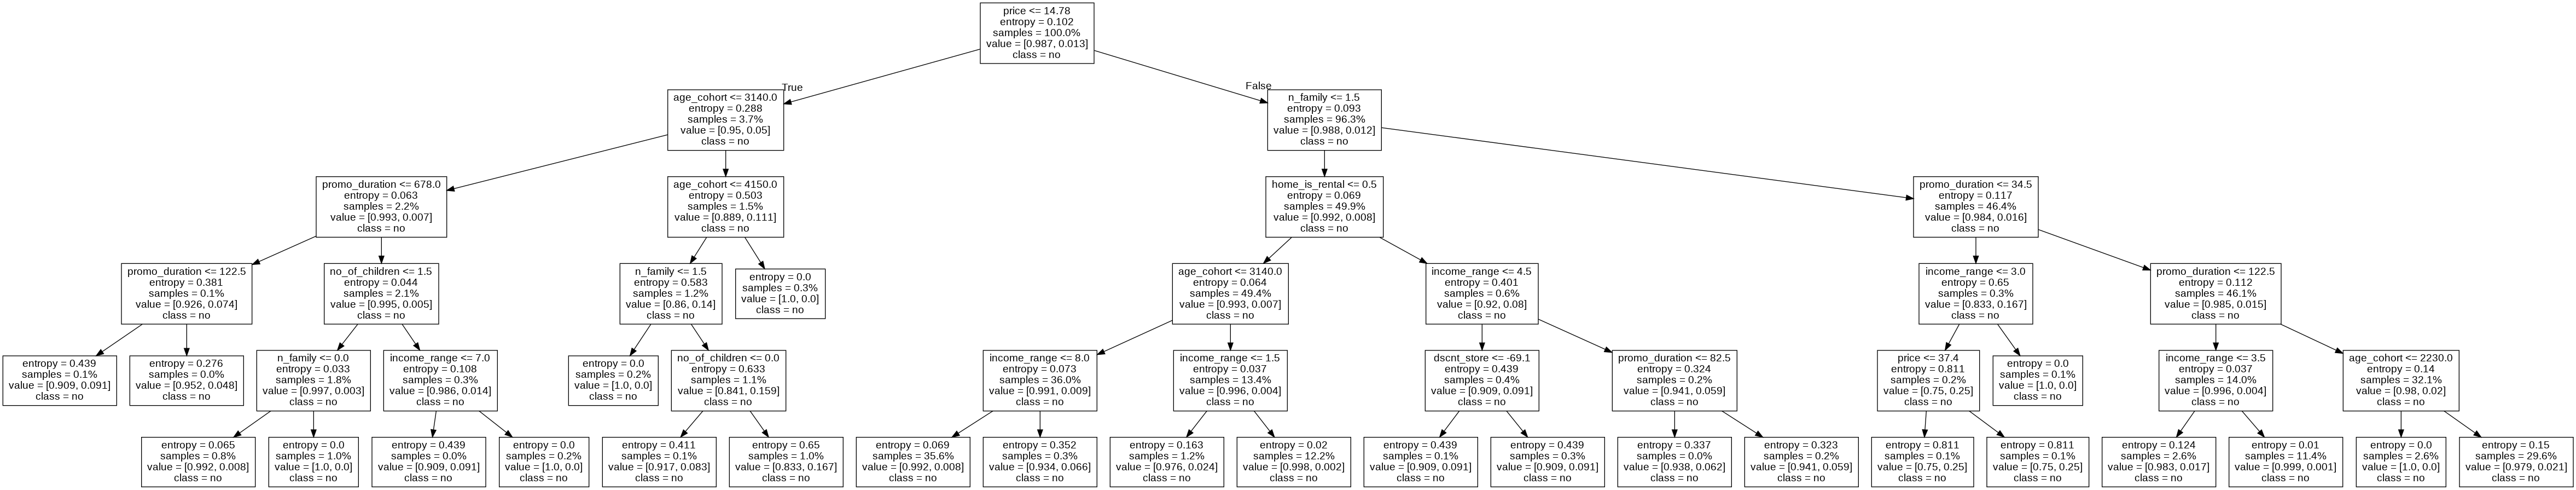

In [26]:
from IPython.display import Image
from sklearn.tree import export_graphviz

visualize_tree(decision_tree, predictor_cols, ["no", "redeemed"])

Notice every leaf node are labeled as no redemption. That might due to the fact that 99% of the data are no redemption and only around 1% are actually redeemed. 

Maybe we should create more levels? or maybe we should turn to some other methods?


# Logic regression


In [9]:

pd.set_option('display.max_columns', None)
df.head()


y_redeemed  year       date  cust_id  prod_id  manuf   brand_type category  \
0           0  2013 2013-02-22     1489    34047     56        Local  Grocery   
1           0  2013 2013-02-22     1489    35464     56        Local  Grocery   
2           0  2013 2013-03-03     1489    34047     56        Local  Grocery   
3           0  2013 2013-03-03     1489    33688    939  Established  Grocery   
4           0  2013 2013-03-05     1489    34047     56        Local  Grocery   

   y_qty   price  dscnt_store  y_dscnt_pcode  c_id c_type start_date  \
0      1   91.19         0.00            0.0     8      X 2013-02-16   
1      1   21.02         0.00            0.0     8      X 2013-02-16   
2      1   91.19         0.00            0.0     8      X 2013-02-16   
3      1  124.31       -10.69            0.0     8      X 2013-02-16   
4      1   91.19         0.00            0.0     8      X 2013-02-16   

    end_date  redemption_id age_cohort marital_status  home_is_rental  \
0 2013-05-04              9      46_55        Married               0   
1 2013-05-04              9      46_55        Married               0   
2 2013-05-04              9      46_55        Married               0   
3 2013-05-04              9      46_55        Married               0   
4 2013-05-04              9      46_55        Married               0   

   n_family  no_of_children  income_range  promo_duration  
0         2              -1             3              77  
1         2              -1             3              77  
2         2              -1             3              77  
3         2              -1             3              77  
4         2              -1             3              77

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

f   = 'y_redeemed ~ lnPrice + dscnt_store + c_id + promo_duration + category_Grocery + age_cohort_18_25 + age_cohort_26_35 + age_cohort_36_45 + age_cohort_46_55 + age_cohort_71 +  marital_status_Married + home_is_rental_1 + home_is_rental_0 + income_range_1 + income_range_2 + income_range_3 + income_range_4 + income_range_5 + income_range_6 + income_range_7 + income_range_8 + income_range_9 + income_range_10 + income_range_12 + income_range + n_family_1 + n_family_2 + n_family_3 + n_family_4 + n_family_5 +  promo_duration'

model_ols_sm = smf.ols(f, data=df_train).fit()
print(model_ols_sm.summary())

                            OLS Regression Results                            
Dep. Variable:             y_redeemed   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     65.72
Date:                Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:48:58   Log-Likelihood:                 99126.
No. Observations:              131523   AIC:                        -1.982e+05
Df Residuals:                  131495   BIC:                        -1.979e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

R square is very low. Maybe we could include more variables and see what would change. 




# To do: make predictions on differenct models and check the accuracy

# (Unedited HW2 codes below)

---




## Q1: Fit a statsmodel logit model to the data to estimate the probability that Sales will be 'low' for for a given day based on knowlege of observable day of the week and holiday features. Low being a standard deviation less than all sales. Use the code and baseline provided in HW 1 Solutions video

# 新增區段

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

dat = working_df

f = 'lowSalesFlag ~ Promo + SchoolHoliday + DayOfWeek_2 + DayOfWeek_3 + DayOfWeek_4 + DayOfWeek_5 + DayOfWeek_6 + DayOfWeek_7 + StateHoliday_a + StateHoliday_b + StateHoliday_c '

model_logit = smf.logit(f,data = dat).fit()
print(model_logit.summary())

mfx = model_logit.get_margeff()
print(mfx.summary())

In [ ]:
testing_df            = df_test[df_test["Open"] == 1] # eliminate observations for closed stores
testing_df['lnSales'] = np.log(testing_df["Sales"]+1)       # Take log add 1 to account for for zero sales days

mu = testing_df["lnSales"].mean()
sigma = testing_df["lnSales"].std()
x = np.array(testing_df["lnSales"])
z = (x - mu)/ sigma

testing_df['zSales'] = z #set to new column for z score
testing_df['lowSalesFlag'] = [1 if s <= -1 else 0 for s in testing_df['zSales']] # set low flag column where z score is low

testing_df = pd.concat([testing_df, ((pd.get_dummies(testing_df['DayOfWeek'], drop_first=True, prefix = "DayOfWeek")))], axis = 1, join = 'inner') #Use pd.get_dummies to convert 'DayOfWeek' to dummy variable
testing_df = pd.concat([testing_df, ((pd.get_dummies(testing_df['StateHoliday'], drop_first=True, prefix = "StateHoliday")))], axis = 1, join = 'inner') #Use pd.get_dummies to convert 'StateHoliday' to dummy variable 




# Helper function

def cm2accuracy(tab):                    # convert 2x2 confusion matrix to accuracy (pct correct)
    correct  = (tab[0][0] + tab[1][1])
    total    = sum(sum(tab))
    accuracy = correct/total
    return(accuracy)

p_baseline           = np.mean(working_df['lowSalesFlag'])

# Calculate accuracy of statsmodels logit model using statsmodels pred.table (confusion matrix)

## Use the threshold above
logit_pred_tab     = model_logit.pred_table(p_baseline)
model_logit_accuracy  = cm2accuracy(logit_pred_tab)
print("Threshold:")
print(p_baseline)
## Use the threshold above

print("Confusion Matrix: Low Sales = 1)")
print(pd.DataFrame(np.round(logit_pred_tab,0)))
print("Accuracy (statsmodels): ",np.round(model_logit_accuracy,5))


#accuracy = (pred == true).mean()
#print(f"Accuracy: {accuracy:.2f}")

## Q2: Fit an sklearn Logit to the data, report your results as above. Were they significantly different? Why or why not? This question may require you checking out the documentation

In [ ]:
from sklearn.linear_model import LogisticRegression


feature_cols = ['Promo', 'Promo', 'DayOfWeek_2', 'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
X = working_df[feature_cols] # Features
y = working_df.lowSalesFlag # Target variable

X_test = testing_df[feature_cols]
y_test = testing_df.lowSalesFlag

clf = LogisticRegression(random_state=0).fit(X,y)
clf.predict(X_test)

#clf.predict_proba(X[:2, :])

print(clf.score(X, y))
print(clf.score(X_test, y_test))



In [ ]:
clf.predict_proba(X[:])


Yes, they are significantly different. The accuracy of statsmodel is around 0.54, while the score of sklearn reaches 0.86.

Although statsmodel and scikit-learn both use OLS model in this case, the reason that the two results are significantly different is due to their different approaches. 


The statsmodel provides a detailed statistical summary which is very similar to Stata and R. And the OLS in scikit-learn is much more focused on prediction, or machine learning ability rather than a plain summary. 

More specifically from their individual documentation, scikit-learn applies parameter regularization by default. It means adding extra information to the data in order to prevent overfitting. Meanwhile, statsmodel doesn't apply parameter regularization. And statsmodel doesn't include the intercept by default. 


## Q3 Fit a Tree Classifier (sklearn) to model the probability that sales will be low. What are the most important features? What does this tell you about the data?

In [ ]:
from sklearn.tree import DecisionTreeClassifier


feature_cols = ['Promo', 'Promo', 'DayOfWeek_2', 'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
X = working_df[feature_cols] # Features
y = working_df.lowSalesFlag # Target variable


X_test = testing_df[feature_cols]
y_test = testing_df.lowSalesFlag

model = DecisionTreeClassifier(max_depth=3, criterion="entropy")
model.fit(X,y)
pred = model.predict(X_test)
true = testing_df['lowSalesFlag']

print(f"Accuracy: {(pred == true).mean():.2f}")

In [ ]:
## helper function for visualization

import matplotlib.pylab as plt

def bool2txt(x,text):
    if x==0 : 
        return text[0]
    else: 
        return text[1]


def visualize_tree(decision_tree, feature_names, class_names, directory="/content/dsclass2022/Module_4_Trees/images", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)
    

import copy as c
def Decision_Surface(data, col1, col2, target, orig_model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()

    # ipdb.set_trace()  # insert this line into any Python code for debugging.  'n' in the dialog box moves to the next line of code
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    # make a copy of the model so we don't corrupt the original
    model = c.deepcopy(orig_model)
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)  
        
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot    
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in df[target_col]]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="target", frameon=True)
    plt.show() 
    

In [ ]:
### Print feature importances

from IPython.display import Image
from sklearn.tree import export_graphviz


visualize_tree(model, feature_cols, 'lowSalesFlag')

#tree_depth=1

#model = DecisionTreeClassifier(max_depth=tree_depth, criterion="entropy")
#Decision_Surface(testing_df, "Promo", "SchoolHoliday", testing_df.lowSalesFlag, model)


From the tree above, we can tell that 'Promo' is the most important factor of all. It is located in the first node. By the greedy algorithm it uses, that means 'Promo' is the factor with the highest information gain.  

Secondly, DayOfWeek_5 and DayOfWeek_4 are located in the second level, which means they have the second largest information gain. 

Within this classification tree with three levels, we can tell which variables have the greater influence than others. 


## Q4 (Regression Trees) Let's build a regression tree to model Log Sales. Compare it with a Linear Regression -- does it work better?

In [ ]:
## Helper function
def report_reg_results(model,train_X,train_Y,test_X,test_Y):
    model.fit(train_X,train_Y)

    pred = model.predict(test_X)
    act = test_Y
    errors    = pred - act
    err       = np.array(errors)

    err2      = np.mean(err**2)
    MAD       = np.abs(np.median(err))
    RMS       = np.sqrt(np.mean(err2))
    r         = np.corrcoef(act,pred)[0,1]
    pseudo_R2 = r**2

    print('RMS = %.3f; MAD= %.3f; pseudo-R2 = %.3f' % (RMS,MAD,pseudo_R2))

    pred_df = pd.DataFrame({"actual":act, "predicted":pred})
    plt_df  = pred_df.sample(n=1000, replace=False, random_state=123).sort_index()
    plt_min = np.min(np.min(plt_df))
    plt_max = np.max(np.max(plt_df))
    plt_col = np.where(plt_df['actual']<plt_df['predicted'],"red","blue")

    fig, ax = plt.subplots()
    ax.scatter(plt_df['actual'], y=plt_df['predicted'],c=plt_col)
    ax.set_xlim(plt_min,plt_max)
    ax.set_ylim(plt_min,plt_max)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("lnSales: Actual vs. Predicted")
    fig
    print(pred_df.describe())

In [ ]:
from sklearn.tree import DecisionTreeRegressor
feature_cols = ['Promo', 'Promo', 'DayOfWeek_2', 'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
X = working_df[feature_cols] # Features
y = working_df.lnSales # Target variable

X_test = testing_df[feature_cols]
y_test = testing_df.lnSales

model = DecisionTreeRegressor(random_state=0)
model.fit(X,y)

print("The model training score is" , model.score(X, y))

report_reg_results(model, X, y, X_test, y_test)

Yes, it does perform better - but only slightly better. 

Recall the result from the linear model, we have:

RMS = 0.386; MAD = 0.033; pseudo-R2 = 0.179

Despite the tiny improvement of MAD (0.003) and pseudo-R2 (0.005), the result using a decision tree regressor still performs poorly with a pseudo-R2 = 0.184 , which barely explains anything.


## Q5: Discuss your results. Why are the predictors performing similarly in both classification and regression? What do you think can make them better?

The pseudo-R2 for both predictors are both around 0.18. The classification only slightly improves the performance. 

Here the target variable (lnSales) is a continuous value ranging around [8.5, 9.5], however, all the feature variables (X) are binary. This means most change of the variables are small relative to the intercept, and it is hard for these coefficients to affect the result from the high constant of lnSales. Even if we introduce the classification, the X variables still lack explanatory power. 

We can probably change to a better model or gain some more useful data to make the prediction better. 

## Part 2

# Predicting Churn

After discussing the churn problem at TelCo with Henrietta for a while (remember, from your pre-class assignment?), you've finally defined an adequate target variable for churn and gathered relevant data to predict it. Moreover, the marketing department has come up with an amazing retention offer: the offer is guaranteed to convince customers to extend their contract for an extra year after receiving it. Unfortunately, the offer is quite expensive; it costs $200. 

You've been authorized to give the retention offer to up to 25% of the customers whose contract is expiring. It is your job to use data from previous contract expirations to build a churn predictive model and make a recommendation of whom to target with the offers. The historical data includes:

- Gender: Whether the customer is a male or a female
- SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
- Partner: Whether the customer has a partner or not (Yes, No)
a- tenure: Number of months the customer has stayed with the company
- PhoneService: Whether the customer has a phone service or not (Yes, No)
- MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)
- OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)
- Contract: The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges: The amount charged to the customer monthly
- Churn: Whether the customer churned or not shortly after contract expiration (Yes or No)

__1. Load the churn data. The code below will also transform your categorical variables into dummy variables. No points for this. This is just meant to help you get started.__

In [ ]:
import numpy as np
import pandas as pd

# Just change the path below so that it points to your file.
data_path = "/content/dsclass2022/Homeworks/data-hw2.csv" 
#data_path = "https://raw.githubusercontent.com/bwolfson2/dsclass2022/main/Homeworks/data-hw2.csv"
df = pd.read_csv(data_path)
df = pd.get_dummies(df, drop_first=True)

print(df.columns)

__2. Split the data into 80% training data and 20% test data.__

In [ ]:
# Your code goes here

from sklearn.model_selection import train_test_split # Import train_test_split function

feature_cols = df.loc[:, df.columns!= 'Churn_Yes']


X = feature_cols # Features
y = df['Churn_Yes'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=0) # 80% training and 20% testing

X_train[:10]


__3. Build the best model you can for each of the following three model types:__
- __A decision tree classifier. Try different values for the parameter min_samples_leaf.__
- __A logistic regression. Try different values for the parameter C.__
- __A third model of your choice. Some suggestions: KNN, SVM, etc. Try different paramater values for this one too.__

__Optimize in terms of their generalization performance using ROC Area and cross-validation with 10 folds. Remember to use only the training data (do not use the test data at all for this example). For each of these model types, you should report the best parameter value you found and the corresponding ROC Area in the cross-validation. Your code should also show the process you went through to try different complexity parameter(s) for each model type. Pick one model to move forward with. Why did you select this one?__

__HINT: There is an example below of the ROC Area for a DecisionTreeClassifier using cross validation.__  

###3.1 Decision Tree Classifier:

In [ ]:
# 1. decision tree classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

target = "Churn_Yes"
#predictors = training_data.columns[training_data.columns != target]

#print(predictors)
example_model = DecisionTreeClassifier()
# Remember to only use the training data here!!
#avg_auc = cross_val_score(example_model, training_data[predictors], training_data[target], cv=10, scoring="roc_auc").mean()
avg_auc = cross_val_score(example_model, X_train, y_train, cv=10, scoring="roc_auc").mean()
print(avg_auc)


####

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_train)


In [ ]:
# try different parameters:

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
#%matplotlib inline

# testing on 2^n as parameters
min_samples_leaf = [(2 ** i) for i in range(10)]

# plot different result from different parameters
for j in min_samples_leaf:
    tree_clf = DecisionTreeClassifier(min_samples_leaf = j)
    train_sizes, train_scores, test_scores = learning_curve(tree_clf, X_train, y_train, cv=5)
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis = 1), label = "Training")
    plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = "Cross-Validated")
    plt.title("Min samples leaf = " + str(j))
    plt.legend()

In [ ]:
range_leaf = [(2**i) for i in range(12)]

print(range_leaf)

accuracy_roc = []
accuracy_f1 = []
accuracy_scores = []
accuracy_precision = []
accuracy_balanced = []
accuracy_recall = []



for j in range_leaf:
  tree_clf = DecisionTreeClassifier(min_samples_leaf = j)
  tree_clf.fit(X_train, y_train)
  y_pred = tree_clf.predict(X_train)

  roc = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="roc_auc", cv=5))
  f1 = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="f1", cv=5))
  accu = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="accuracy", cv=5))
  precision = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="average_precision", cv=5))
  balanced = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="balanced_accuracy", cv=5))
  recall = np.mean(cross_val_score(tree_clf, X_train, y_train, scoring="recall", cv=5))


  accuracy_roc.append(roc)
  accuracy_f1.append(f1)
  accuracy_scores.append(accu)
  accuracy_precision.append(precision)
  accuracy_balanced.append(balanced)
  accuracy_recall.append(recall)




ticks = range_leaf
labels = ['{}'.format(v) for v in ticks]
  
plt.plot(range_leaf, accuracy_roc, label = "ROC_AUC")
plt.plot(range_leaf, accuracy_f1, label = "F1")
plt.plot(range_leaf, accuracy_scores, label = "Accuracy")
plt.plot(range_leaf, accuracy_precision, label = "Precision")
plt.plot(range_leaf, accuracy_balanced, label = "Balanced")
plt.plot(range_leaf, accuracy_recall, label = "Recall")


plt.xlabel('Leaf Samples for Decision Tree')
plt.ylabel('Training Score')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.legend();


Here the graph shows the model has most accuracy around 64 leaves. Then the accuracy drops. 

Therefore, we take 64 as our parameter and calculate the accuracy below:


In [ ]:
# print the accuracy of 64 leaves


tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="accuracy").mean()
roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

print("Accuracy - 64 Leafs: ", accuracy_cv.round(3))
print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
print("F1 - 64 Leafs:       ", f1.round(3))

In [ ]:

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Remember to use the training data here!! 

tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="accuracy").mean()
roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

print("Accuracy - 64 Leafs: ", accuracy_cv.round(3))
print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
print("F1 - 64 Leafs:       ", f1.round(3))


# And to use the test data here!!
probs = tree_clf_64.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label="Decision Tree")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()



###3.2 Logistic Regression:

In [ ]:
## 2. logistic regression

c_range = [(10**i) for i in range(-3, 4)]
#c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#ticks = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

print(c_range)

accuracy_roc = []
accuracy_f1 = []
accuracy_scores = []
accuracy_precision = []
accuracy_balanced = []
accuracy_recall = []

for c in c_range:
  log_reg = LogisticRegression(C=c)
  log_reg.fit(X_train, y_train)
  y_pred_log = log_reg.predict(X_train)

  roc = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="roc_auc", cv=5))
  f1 = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="f1", cv=5))
  accu = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="accuracy", cv=5))
  precision = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="average_precision", cv=5))
  balanced = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="balanced_accuracy", cv=5))
  recall = np.mean(cross_val_score(log_reg, X_train, y_train, scoring="recall", cv=5))


  accuracy_roc.append(roc)
  accuracy_f1.append(f1)
  accuracy_scores.append(accu)
  accuracy_precision.append(precision)
  accuracy_balanced.append(balanced)
  accuracy_recall.append(recall)


ticks = c_range
labels = ['{}'.format(v) for v in ticks]
  
plt.plot(c_range, accuracy_roc, label = "ROC_AUC")
plt.plot(c_range, accuracy_f1, label = "F1")
plt.plot(c_range, accuracy_scores, label = "Accuracy")
plt.plot(c_range, accuracy_precision, label = "Precision")
plt.plot(c_range, accuracy_balanced, label = "Balanced")
plt.plot(c_range, accuracy_recall, label = "Recall")


plt.xlabel('Leaf Samples for Decision Tree')
plt.ylabel('Training Score')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.legend();




It seems that the accuracy reaches the peak when c reaches 0.1 and the accuracy does not increase furthermore as c increases. 

The accuracy remains the same even if we increase the c to 1000.
Therefore, we pick c = 0.1 and run the result.

In [ ]:
# confirm accuracy and ROC AUC scores @ C = 0.1
log_reg_c = LogisticRegression(max_iter=1000, C=0.1)
log_reg_c.fit(X_train, y_train)
y_pred_c = log_reg_c.predict(X_train)
accuracy_cv = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="accuracy").mean()
roc_auc = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1 = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="f1").mean()

print("Accuracy:", accuracy_cv.round(3))
print("ROC AUC:", roc_auc.round(3))
print("F1:", f1.round(3))

In [ ]:

probs_lr = log_reg_c.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, probs_lr)

plt.figure(figsize=(10, 10))
plt.plot(fpr2, tpr2, label="Log Regression")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

###3.3 KNN:

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

k_range = [2**i for i in range(10)] # from 1 to 512


# store results
accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []
AUC_scores = []

# loop function for cross validation
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred_knn = knn.predict(X_train)
  scores = accuracy_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="accuracy").mean())
  f1 = F1_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="f1").mean())
  avg_precision = precision_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="average_precision").mean())
  recall = recall_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="recall").mean())
  avg_auc = AUC_scores.append(cross_val_score(knn, X_train, y_train, cv=5, scoring="roc_auc").mean())

# plot graph
ticks = [1, 5, 10, 30, 50, 75, 100]
ticks = k_range
labels = ['{}'.format(v) for v in ticks]
  
plt.plot(k_range, accuracy_scores, label = "Accuracy")
plt.plot(k_range, precision_scores, label = "Precision")
plt.plot(k_range, recall_scores, label = "Recall")
plt.plot(k_range, F1_scores, label = "F1")
plt.plot(k_range, AUC_scores, label = "AUC")

plt.xlabel('Value of K for KNN')
plt.ylabel('Training Score')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.legend();

The accuracy seems to reach the peack when K is around 64.

Therefore, we pick 64 as our parameter and check its result.


In [ ]:
# check accuracy and ROC AUC scores when K = 64 
# K = 64
knn_64 = KNeighborsClassifier(n_neighbors=64)
knn_64.fit(X_train, y_train)
y_pred_knn_64 = knn.predict(X_train)
accuracy_cv_64 = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="accuracy").mean()
roc_auc_64 = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1_64 = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="f1").mean()

print("Accuracy - K=64 :", accuracy_cv_64.round(3))

print("ROC AUC - K=64  :", roc_auc_64.round(3))

print("F1 - K=64       :", f1_64.round(3))



In [ ]:
probs_knn = knn_64.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, probs_knn)

plt.figure(figsize=(10, 10))
plt.plot(fpr3, tpr3, label="KNN")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()


Overall, the accuracy from all three models shows a relatively good result. 

They show concave shape as expected and their ROC AUC are high (around 0.8).

Among all, the logistic regression shows the better result since the ROC AUC is the highest (0.844), therefore I would pick this model and continue. 



__4. Use your test data to plot the ROC Curves for each of the three best models you found in the previous question (make sure to plot the three curves together). Would you consider changing the selected model after looking at the curves? If yes, explain why. If not, explain what would the curves need to look like for you to consider changing the selected model.__

__HINT: There is an example below of the ROC curve for the DecisionTreeClassifier that was used earlier__

In [ ]:
# The code below is just meant as an example for you to plot the ROC curve.
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Remember to use the training data here!! 
#example_model.fit(training_data[predictors], training_data[target])
example_model.fit(X_train, y_train)

# And to use the test data here!!
#probs = example_model.predict_proba(testing_data[predictors])[:, 1]
#fpr, tpr, thresholds = roc_curve(testing_data[target], probs)
probs = example_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)


plt.plot(fpr, tpr, label="An Example")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

In [ ]:
tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="accuracy").mean()

print("Accuracy - 64 tree leaves   : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="accuracy").mean()
print("Accuracy - Logistic Regression : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="accuracy").mean()
print("Accuracy - 64 KNN       : ", accuracy_cv.round(3))

#roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
#f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

#print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
#print("F1 - 64 Leafs:       ", f1.round(3))




# And to use the test data here!!
probs = tree_clf_64.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)


probs_lr = log_reg_c.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, probs_lr)

probs_knn = knn_64.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, probs_knn)



plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label="Decision Tree")
plt.plot(fpr2, tpr2, label="Log Regression")
plt.plot(fpr3, tpr3, label="KNN")

plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()


In [ ]:
tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()

print("ROC_AUC - 64 tree leaves   : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="roc_auc").mean()
print("ROC_AUC - Logistic Regression : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
print("ROC_AUC - 64 KNN       : ", accuracy_cv.round(3))

#roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
#f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

#print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
#print("F1 - 64 Leafs:       ", f1.round(3))




# And to use the test data here!!
probs = tree_clf_64.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)


probs_lr = log_reg_c.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, probs_lr)

probs_knn = knn_64.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, probs_knn)



plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label="Decision Tree")
plt.plot(fpr2, tpr2, label="Log Regression")
plt.plot(fpr3, tpr3, label="KNN")

plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()


In [ ]:
tree_clf_64 = DecisionTreeClassifier(min_samples_leaf=64)
tree_clf_64.fit(X_train, y_train)
y_pred_64 = tree_clf_64.predict(X_train)
accuracy_cv = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

print("F1 - 64 tree leaves   : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(log_reg_c, X_train, y_train, cv=5, scoring="f1").mean()
print("F1 - Logistic Regression : ", accuracy_cv.round(3))

accuracy_cv = cross_val_score(knn_64, X_train, y_train, cv=5, scoring="f1").mean()
print("F1 - 64 KNN       : ", accuracy_cv.round(3))

#roc_auc = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="roc_auc").mean()
#f1 = cross_val_score(tree_clf_64, X_train, y_train, cv=5, scoring="f1").mean()

#print("ROC AUC - 64 Leafs:  ", roc_auc.round(3))
#print("F1 - 64 Leafs:       ", f1.round(3))




# And to use the test data here!!
probs = tree_clf_64.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)


probs_lr = log_reg_c.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, probs_lr)

probs_knn = knn_64.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, probs_knn)



plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label="Decision Tree")
plt.plot(fpr2, tpr2, label="Log Regression")
plt.plot(fpr3, tpr3, label="KNN")

plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

Base on the graphs above, the best model is the linear regression, which has the highest accuracy of all. 

The performance of KNN is slightly lower than decision tree and log regression in this case. 

Overall, I would consider using Logistic Regression model since it has the hightest accuracy, F1, and ROC. 

In terms of changing models, I would consider changing the models if the ROC curve of the chosen model is lower than others, or if the curve is not concave. 